This notebook will walk through (my attempts at) an implementation of convolutional neural nets for image classification, mostly emphasizing ResNet. For our purposes, I will use the CIFAR-10 dataset.

In [1]:
# Author: Tyna Eloundou
# Package import

# Ordinary Python
import matplotlib.pyplot as plt
import numpy as np

# PyTorch
import torch
import torchvision
import torchvision.transforms as transforms

# CNN Libraries
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler, Optimizer


In [2]:
# !jupyter nbextension enable --py widgetsnbextension --sys-prefix

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
# from tqdm import tqdm_notebook as tqdm
# Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave = True)
# from tqdm.notebook import tqdm

Here we set the path variables/objects. Make sure to make these relative to current directory, for porting back and forth from GPU.

In [4]:

"""
Define Paths
"""

PATH = './cifar10_resnet.pth'


# DATA_PATH=Path('./data/')
# DATA_PATH.mkdir(exist_ok=True)

# PATH=Path('./data/tmp/')
# PATH.mkdir(exist_ok=True)

# model_state_dict = None




In [5]:
args = {
    "train_size": -1,
    "val_size": -1,
#     "full_data_dir": DATA_PATH,
    "data_dir": PATH,
    "task_name": "cifar10",
    "no_cuda": False,
#     "output_dir": CLAS_DATA_PATH/'output',
    "do_train": True,
    "do_eval": True,
    "train_batch_size": 5,
    "eval_batch_size": 5,
    "learning_rate": 3e-5,
    "num_train_epochs": 2.0,
    "warmup_proportion": 0.1,
    "local_rank": -1,
    "seed": 42,
    "gradient_accumulation_steps": 1,
    "optimize_on_cpu": False,
    "fp16": False,
    "loss_scale": 128,
    "mean_val": 0.5,
    "sd_val": 0.5,
    "batch_sz" : 5
}

First, we think about how to transform our data, once we pull it. The **Compose** callable class allows us to stack transformations on top of each other. Here, we are interested in normalizing the color in our tensor images, towards a mean of 0.5 and standard deviation of 0.5. This is important because we do not want our model to be unnecessarily biased by color distribution in examples, or a set of examples. 

Note that color images have three channels: red, green and blue. We therefore need to pass three parameters each for normalizing the mean and standard deviations.

In [6]:
# transform
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((args["mean_val"], args["mean_val"], args["mean_val"]), (args["sd_val"], args["sd_val"], args["sd_val"]))])


Then, we define the batch size to be 5. Then we define the training and test sets, transforming them and downloading if necessary. We then load the data, setting **shuffle** to True for the training data to reshuffle after every epoch.

In [7]:

# Download training set from CIFAR10, using the transform defined above
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Load the data using a dataloader, from the training set, with batchsize 5 and multi processing (workers)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args["batch_sz"], shuffle=True, num_workers=2)

# Test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=args["batch_sz"],  shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


From the CIFAR documentation, get the class names. We can abbreviate them or use shortened version, as long as we do not change the meaning. Note that the labels were initially generated to be mutually exclusive.

In [8]:
#set class names for CIFAR-10

classes = ('plane', 'car', 'bird', 'cat', 'deer',
            'dog', 'frog', 'horse', 'ship', 'truck')

classes2 = ('airplane', 'automobile', 'bird', 'cat', 'deer',
            'dog', 'frog', 'horse', 'ship', 'truck')

For the exploratory phase, let us define a function to display our images. We take advantage of matplotlib's **imshow** method to do this. 

Using **iter()** combined with **next()**, we can create iterations of images in our training set to view, and print their true labels just underneath.

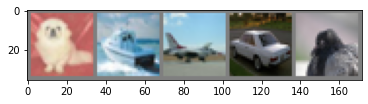

  dog       ship      plane        car       bird


In [9]:
# Display pictures


def show_image(img):
    img = img*args["mean_val"] + args["sd_val"]     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # use imshow to display data as an image, i.e., on a 2D regular raster.
    plt.show()

# get some random training images from the dataloader
dataiter = iter(trainloader) # iter() creates an object which can be iterated one element at a time, esp with next()
images, labels = dataiter.next()

# show images in a batch (click this cell a couple of time to see several batches)
show_image(torchvision.utils.make_grid(images))
# print labels for a batch
print('      '.join('%5s' % classes[labels[j]] for j in range(args["batch_sz"])))


Now, we can take the Module class to create our 3-channel images. Her, we have a basic architecture that starts with 3 in-channels and goes in the sequence: 

Conv Layer -> ReLU -> Max Pooling -> Conv Layer -> ReLU -> Max Pooling -> ReLU(Fully Connected) -> ReLU(Fully Connected) -> Fully Connected 

In [10]:
# Define a CNN and modify to take 3-channel images

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # nn.Conv2d(in_channels, out_channels, kernel_size)
        self.pool = nn.MaxPool2d(2, 2)   # nn.MaxPool2d(kernel_size, stride)    #think about removing the pools
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #nn.Linear(in_features, out_features)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):  # forward prop architecture
        x = self.pool(F.relu(self.conv1(x)))  # use conv1, then relu to squish values, then pool
        x = self.pool(F.relu(self.conv2(x)))  # use conv2, then relu to squish values, then pool
        x = x.view(-1, 16 * 5 * 5)            # view method returns a tensor with the same data as the self tensor (the returned tensor has the same number of elements), but with a different shape. 
        x = F.relu(self.fc1(x))               # fully connected layer fc1, then relu
        x = F.relu(self.fc2(x))               # fully connected layer fc2, then relu
        x = self.fc3(x)                       # fully connected layer, corresponds to final output
        return x


net = Net()

At this junction, we should think about our choice of loss function and optimizers. 

There are a number of loss criteria and optimizers at our disposal, but we will start with cross entropy loss and stochastic gradient descent.

In [11]:
# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()    #cross entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)   # start with learning rate of 0.001 for stochastic GD

Now, we train over 2 epochs for our training set of 10000, printing loss metrics after 2000 examples.

In [12]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data         # get the inputs; data is a list of [inputs, labels]
        optimizer.zero_grad()         # zero the parameter gradients

        # forward pass + backprop + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print_interval = 2000 # number of mini-batches after which to evaluate running loss
        
        if i % print_interval == print_interval-1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_interval))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.161
[1,  4000] loss: 1.786
[1,  6000] loss: 1.642
[1,  8000] loss: 1.567
[1, 10000] loss: 1.499
[2,  2000] loss: 1.424
[2,  4000] loss: 1.397
[2,  6000] loss: 1.377
[2,  8000] loss: 1.347
[2, 10000] loss: 1.317
Finished Training


In [14]:
torch.save(net.state_dict(), PATH)

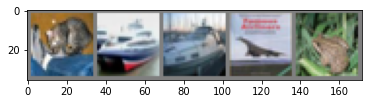

GroundTruth:    cat  ship  ship plane  frog


In [15]:
# Test Set (take a batch from the test dataloader, assign them to images and their real labels)
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
show_image(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(args["batch_sz"])))


In [16]:
# Loading the network back up (unnecessary)
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
outputs = net(images)   # predictions of the network for the test set

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]  for j in range(args["batch_sz"])))

Predicted:    cat plane   car plane  frog


In [18]:
# Transfer the neural net onto the GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() and not args["no_cuda"] else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

# How many GPUs? Should be 4 Tesla V100s

n_gpu = torch.cuda.device_count()
print(n_gpu)



cuda:0
4


Now we define an evaluation metric for the net, overall accuracy and per class accuracy.

In [19]:

def accuracy_monitor(trained_net, n_class):
    correct = 0
    total = 0
    
    class_correct = list(0. for i in range(n_class))
    class_total = list(0. for i in range(n_class))

    
    with torch.no_grad():   # no gradient calculation
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            trained_net = trained_net.to(device)
            outputs = trained_net(images)

            _, predicted = torch.max(outputs.data, 1)   # extract predictions

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            c = (predicted == labels).squeeze()
            for i in range(args["batch_sz"]):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
        

In [20]:
accuracy_monitor(net, n_class=10)

Accuracy of the network on the 10000 test images: 53 %
Accuracy of plane : 70 %
Accuracy of   car : 75 %
Accuracy of  bird : 29 %
Accuracy of   cat : 46 %
Accuracy of  deer : 45 %
Accuracy of   dog : 36 %
Accuracy of  frog : 72 %
Accuracy of horse : 57 %
Accuracy of  ship : 42 %
Accuracy of truck : 60 %


Hmm, better than random (1/#classes ~ 10%), but we would ideally want to see if we can boost this.

Now, let us try to improve this a little bit towards **SotA** performance. The SoTA ResNet structure we will try to adopt is from [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf).

The one thing I would like to probe a bit are the **optimizer** parameters. Used some insight from [Machine Learning from Scratch](https://mlfromscratch.com/optimizers-explained/#/) as a guide.

Take a lead from In "Bag of Tricks for Image Classification with Convolutional Neural Networks", Tong He et al., where instead of just starting with ResNet blocks, it begins with a few convolutional layers followed by a max pooling layer. The first layers are called the stem of the network.

In [22]:
# Define a modular class for convolution layer with ReLU as activation and BatchNorm
class BaseConv(nn.Module):

    def __init__(self, input_channels, output_channels, kernel_size, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size, **kwargs)
        self.batchnorm = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.relu(self.batchnorm(self.conv(x)))

        return x

Now that we have created a modular convolution layer class, we can use this as one of our building blocks for the resnet blocks.

Initial weighting can influence performance of neural nets. One potential reason is that updating weights after each mini-batch may change the distribution of inputs to layers deep in the network. This is called **internal covariate shift**.

**Batch Normalization** is a technique for training very deep neural nets by standardizing the inputs to a layer for each mini-batch, so the deep layers are not chasing a moving target, which stabilizes the learning process and reduces required training epochs. 

The method by which it does it is by scaling the output of the layer, specifically by standardizing the activations of each input variable per mini-batch, such as the activations of a node from the previous layer. **Standardization** means rescaling data to have a mean of zero and a standard deviation of one, e.g. a standard Gaussian.

Batchnorm can be applied to either the activations of a prior layer or inputs directly.


Define a ResNet block. This will serve as the basis for the ResNet architecture we put together. The all-important residuals are calculated by a sequence of stacked (normalized) convolutions.

In [23]:
class ResBlock(nn.Module):
    """
    Basic Block for small resnets
    """
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * ResBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * ResBlock.expansion)
        )

        #self-convolution loop
        self.selfconv = nn.Sequential()

        #the self-convolution output dimension is not the same as residual function
        #use self-convolution to conform dimensions
        if stride != 1 or in_channels != ResBlock.expansion * out_channels:
            self.selfconv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * ResBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * ResBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.selfconv(x))


Finally, building the ResNet for our dataset requires some stem architecutre.

In [24]:
# Write a stem architecture with flexible size inputs (use the star operator)
def _resnet_stem(*sizes):
    return [ BaseConv(sizes[i], sizes[i+1], 3, stride = 2 if i==0 else 1)  for i in range(len(sizes)-1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

_resnet_stem(3,32,32,64)

[BaseConv(
   (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
   (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
 ),
 BaseConv(
   (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
   (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
 ),
 BaseConv(
   (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
   (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
 ),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

In [25]:
class ResNet(nn.Module):
    
    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64
        
        self.conv0 = nn.Sequential(*_resnet_stem(3,32,32,64))

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        
        #so conv2_x's stride is 1 because of different input size than the original paper
        
        block_sizes = [64, 64, 128, 256, 512]
        
        self.conv2_x = self._make_layer(block, block_sizes[1]*block.expansion, num_block[0], 1)
        self.conv3_x = self._make_layer(block, block_sizes[2]*block.expansion, num_block[1], 2)
        self.conv4_x = self._make_layer(block, block_sizes[3]*block.expansion, num_block[2], 2)
        self.conv5_x = self._make_layer(block, block_sizes[4]*block.expansion, num_block[3], 2)
        
#         self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
#         self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
#         self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
#         self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers one layer may contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        Return:
            return a resnet layer
        """
        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv5_x(self.conv4_x(self.conv3_x(self.conv2_x(self.conv1(x)))))  #convolve
#         x = self.conv5_x(self.conv4_x(self.conv3_x(self.conv2_x(self.conv0(x)))))
        output = self.avg_pool(x)                                                  #pool
        output = output.view(output.size(0), -1)                                   #reshape
        output = self.fc(output)                                                   #fully connected

        return output


In [26]:
# block, num_block, num_classes=10
# num_block <- 
def resnet18():
    """ 
    return a ResNet 18 object
    """
    return ResNet(ResBlock, [2, 2, 2, 2], num_classes=10)

def resnet34():
    """ 
    return a ResNet 34 object
    """
    return ResNet(ResBlock, [3, 4, 6, 3], num_classes=10)






In [27]:
net18 = resnet18()

In [26]:
net34 = resnet34()

In [28]:
def net_trainer(trainloader, optimizer, criterion, neural_net, n_epochs =2, print_interval=2000):
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data         # get the inputs; data is a list of [inputs, labels]
#             inputs = inputs.to(device)
#             labels = labels.to(device)
            optimizer.zero_grad()         # zero the parameter gradients

            # forward pass + backprop + optimize
            outputs = neural_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            if i % print_interval == print_interval-1:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / print_interval))
                running_loss = 0.0

    print('Finished Training')

In [29]:
net_trainer(trainloader=trainloader, 
            criterion=nn.CrossEntropyLoss(), 
            optimizer= optim.SGD(net18.parameters(), lr=0.001, momentum=0.9), 
            neural_net=net18)

#make a note of _resnet_stem not being very effective. Initial loss of 2.216 and final loss of 1.388

# net_trainer(trainloader=trainloader, 
#             criterion=nn.CrossEntropyLoss(), 
#             optimizer= optim.SGD(net34.parameters(), lr=0.001, momentum=0.9), 
#             neural_net=net34)

[1,  2000] loss: 1.864
[1,  4000] loss: 1.484
[1,  6000] loss: 1.275
[1,  8000] loss: 1.122
[1, 10000] loss: 1.018
[2,  2000] loss: 0.902
[2,  4000] loss: 0.839
[2,  6000] loss: 0.799
[2,  8000] loss: 0.761
[2, 10000] loss: 0.744
Finished Training


This looks better than our original effort. What does our accuracy look like?

In [30]:
accuracy_monitor(net18, n_class=10)

Accuracy of the network on the 10000 test images: 73 %
Accuracy of plane : 82 %
Accuracy of   car : 88 %
Accuracy of  bird : 50 %
Accuracy of   cat : 80 %
Accuracy of  deer : 62 %
Accuracy of   dog : 55 %
Accuracy of  frog : 72 %
Accuracy of horse : 78 %
Accuracy of  ship : 87 %
Accuracy of truck : 81 %


Implementing tricks. Earlier, we employed some standard transforms to our data to see performance improvements. Let us see if the tricks from the bag of tricks help us here.

In [31]:
# transform

# We may want to use different transforms for training and testing
train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, saturation=0.4, hue=0.4),
        transforms.ToTensor(),
        transforms.Normalize((args["mean_val"], args["mean_val"], args["mean_val"]), (args["sd_val"], args["sd_val"], args["sd_val"])),
    ])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((args["mean_val"], args["mean_val"], args["mean_val"]), (args["sd_val"], args["sd_val"], args["sd_val"])),
      ])



In [32]:
# Loading the data with our updated transforms for the training set.

trainset_v2 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

# Load the data using a dataloader, from the training set, with batchsize 5 and multi processing (workers)
trainloader_v2 = torch.utils.data.DataLoader(trainset_v2, batch_size=args["batch_sz"], shuffle=True, num_workers=2)

# Test set
testset_v2 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

testloader_v2 = torch.utils.data.DataLoader(testset_v2, batch_size=args["batch_sz"],  shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [33]:
net18 = resnet18()
net_trainer(trainloader=trainloader_v2, 
            criterion=nn.CrossEntropyLoss(), 
            optimizer= optim.SGD(net18.parameters(), lr=0.001, momentum=0.9), 
            neural_net=net18)

[1,  2000] loss: 2.018
[1,  4000] loss: 1.607
[1,  6000] loss: 1.366
[1,  8000] loss: 1.227
[1, 10000] loss: 1.095
[2,  2000] loss: 0.982
[2,  4000] loss: 0.934
[2,  6000] loss: 0.889
[2,  8000] loss: 0.856
[2, 10000] loss: 0.820
Finished Training


In [34]:
accuracy_monitor(net18, n_class=10)

Accuracy of the network on the 10000 test images: 73 %
Accuracy of plane : 79 %
Accuracy of   car : 79 %
Accuracy of  bird : 58 %
Accuracy of   cat : 33 %
Accuracy of  deer : 77 %
Accuracy of   dog : 75 %
Accuracy of  frog : 82 %
Accuracy of horse : 78 %
Accuracy of  ship : 78 %
Accuracy of truck : 89 %


In [36]:
# xavier initialization

def init_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)

            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
            
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    return net

In [37]:
net_reinit18 = resnet18()
net = init_weights(net_reinit18)

In [37]:
net_trainer(trainloader=trainloader, 
            criterion=nn.CrossEntropyLoss(), 
            optimizer= optim.SGD(net.parameters(), lr=0.001, momentum=0.9), 
            neural_net=net)

[1,  2000] loss: 1.924
[1,  4000] loss: 1.540
[1,  6000] loss: 1.345
[1,  8000] loss: 1.186
[1, 10000] loss: 1.079
[2,  2000] loss: 0.932
[2,  4000] loss: 0.902
[2,  6000] loss: 0.852
[2,  8000] loss: 0.831
[2, 10000] loss: 0.771
Finished Training


In [38]:
def net_trainer_gpu(trainloader, optimizer, criterion, neural_net, n_epochs =2, print_interval=2000):
    
    for epoch in tqdm(range(int(n_epochs)), desc="Epoch"):
#     for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(tqdm(trainloader, desc="Iteration"), 0):
#         for i, data in enumerate(trainloader, 0):

            inputs, labels = data         # get the inputs; data is a list of [inputs, labels]
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()         # zero the parameter gradients

            # forward pass + backprop + optimize
            outputs = neural_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            if i % print_interval == print_interval-1:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / print_interval))
                running_loss = 0.0

    print('Finished Training')

In [39]:
net_reinit18 = resnet18()
net = init_weights(net_reinit18)

# net = nn.DataParallel(net, device_ids=torch.cuda.device_count())
net = torch.nn.DataParallel(net, device_ids=[0, 1, 2])
net = net.cuda()


In [40]:
net_trainer_gpu(trainloader=trainloader, 
            criterion=nn.CrossEntropyLoss(), 
            optimizer= optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9), 
            neural_net=net)

Iteration:  20%|██        | 2005/10000 [01:14<04:41, 28.44it/s]

[1,  2000] loss: 2.018


Iteration:  40%|████      | 4003/10000 [02:24<03:44, 26.74it/s]

[1,  4000] loss: 1.620


Iteration:  60%|██████    | 6004/10000 [03:35<02:21, 28.17it/s]

[1,  6000] loss: 1.397


Iteration:  80%|████████  | 8005/10000 [04:46<01:10, 28.46it/s]

[1,  8000] loss: 1.230


Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]]

[1, 10000] loss: 1.105


Iteration:  20%|██        | 2005/10000 [01:13<04:56, 26.93it/s]

[2,  2000] loss: 0.961


Iteration:  40%|████      | 4003/10000 [02:25<03:33, 28.12it/s]

[2,  4000] loss: 0.902


Iteration:  60%|██████    | 6004/10000 [03:36<02:18, 28.82it/s]

[2,  6000] loss: 0.855


Iteration:  80%|████████  | 8005/10000 [04:49<01:10, 28.14it/s]

[2,  8000] loss: 0.805


Epoch: 100%|██████████| 2/2 [11:58<00:00, 359.43s/it]

[2, 10000] loss: 0.762
Finished Training


In [42]:
accuracy_monitor(net, n_class=10)

Accuracy of the network on the 10000 test images: 73 %
Accuracy of plane : 78 %
Accuracy of   car : 90 %
Accuracy of  bird : 43 %
Accuracy of   cat : 41 %
Accuracy of  deer : 71 %
Accuracy of   dog : 75 %
Accuracy of  frog : 84 %
Accuracy of horse : 80 %
Accuracy of  ship : 81 %
Accuracy of truck : 87 %


Files already downloaded and verified
Files already downloaded and verified


In [51]:
class ResD_Block(nn.Module):
    """
    Modified Basic Block (from Tong He paper)
    """
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * ResBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * ResBlock.expansion)
        )

        #self-convolution loop
        self.selfconv = nn.Sequential()

        # change the self-convolution dimension to have average pooling
        if stride != 1 or in_channels != ResBlock.expansion * out_channels:
            self.selfconv = nn.Sequential(
                nn.AvgPool2d(2, stride=2), # square window
                nn.Conv2d(in_channels, out_channels * ResBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * ResBlock.expansion)
                
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.selfconv(x))


In [52]:
def resnet18_d():
    """ 
    return a ResNet 18 object
    """
    return ResNet(ResD_Block, [2, 2, 2, 2], num_classes=10)


In [53]:
net_d = resnet18_d()

In [54]:
net_trainer(trainloader=trainloader, 
            criterion=nn.CrossEntropyLoss(), 
            optimizer= optim.Adam(net_d.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9), 
            neural_net=net_d)

RuntimeError: The size of tensor a (16) must match the size of tensor b (8) at non-singleton dimension 3